In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#Create a Dataframe with 4 season
Data10=pd.read_csv("../Data/2009-2010.csv")
Data9=pd.read_csv("../Data/2008-2009.csv")
Data8=pd.read_csv("../Data/2007-2008.csv")
Data7=pd.read_csv("../Data/2006-2007.csv")
Data=pd.concat([Data7,Data8,Data9,Data10],sort=False,ignore_index=True)
Data=Data[['HomeTeam','AwayTeam','FTHG','FTAG','FTR']]
Data.columns=['Home','Away','HG','AG','Result']
#Take off certain team in order to have a ranking of 20 teams
Out=["Lecce","Messina","Ascoli","Reggina","Empoli","Torino"]
for out in Out:
    Data = Data.loc[Data.Home != out]
    Data = Data.loc[Data.Away != out]
Data=Data.reset_index()
Team=Data.Home.value_counts().index
Data['diff_score']=Data['HG']-Data['AG']


In [3]:
#Create a dataframe with the coefficients to update
coef=pd.DataFrame({'Team':Team})
coef['Att']=np.random.normal(0,0.01,len(coef))
coef['Dif']=np.random.normal(0,0.01,len(coef))
coef.iloc[0]['Att']=coef.iloc[0]['Att'] -sum(coef['Att'].values)
coef.iloc[0]['Dif']=coef.iloc[0]['Dif'] -sum(coef['Dif'].values)
#In order to have identifiability of the covariates 
coef=coef.set_index('Team').sort_index()

delta = np.random.normal(0,0.01)
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))
coef

C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\marco\Desktop\Python\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Att,Dif
Team,,
Atalanta,0.005565,-0.001015
Bari,0.014042,-0.017466
Bologna,-0.006743,0.016702
Cagliari,-0.004959,-0.000408
Catania,-0.003504,0.001549
Chievo,0.007644,0.001237
Fiorentina,-0.000128,0.006342
Genoa,-0.004596,-0.015177
Inter,0.005893,0.004457


In [5]:
#Function to calculate the means for the Poisson distribution
def score_coef(att,dif,delta,Data):
    mu1=np.array([])
    mu2=np.array([])
    for i in Data.index:
        m1=np.exp(delta+att.loc[Data.loc[i].Home]-dif.loc[Data.loc[i].Away])
        m2=np.exp(att.loc[Data.loc[i].Away]-dif.loc[Data.loc[i].Home])
        mu1=np.append(mu1,m1)
        mu2=np.append(mu2,m2)
    return mu1, mu2

In [6]:
#Try to Use a Guassian Normal prior distribution for simplicity. logP(x)/logP(y)
def prior(x,y):
    return -x**2+y**2


In [7]:
#Poisson log-likelihood
def Poiss_log_likeli_dif(mu,new_mu,score):
    D=0
    for i in range(len(score)):
        D+=score.iloc[i]*np.log(new_mu.iloc[i]/mu.iloc[i])-new_mu.iloc[i]+mu.iloc[i]
    return D

In [8]:
mu1, mu2=score_coef(coef['Att'],coef['Dif'],delta,Data)
Data['mu1']=mu1
Data['mu2']=mu2


In [10]:
def MCMC(max_iter,theta0,Data):
    #create vectors to save coef and means at each iteration
    totnameatt= list()
    totnamedef= list()
    theta_t = theta0 
    liste=range(39)
    ret=0;
    coef['Sum_Att']=coef['Att']
    coef['Sum_Dif']=coef['Dif']
    for k in range(max_iter):
        #choose randomly 5 coef to be updated 
        a1, a2, a3, a4, a5 =np.random.choice(liste, 5,replace=False)
        v=0.1
        b1=np.random.normal(0,v)
        b2=np.random.normal(0,v)
        b3=np.random.normal(0,v)
        b4=np.random.normal(0,v)
        b5=np.random.normal(0,v)
        #create a new vector theta
        theta2_t=np.copy(theta_t)
        
        theta2_t[a1]+=b1
        theta2_t[a2]+=b2
        theta2_t[a3]+=b3
        theta2_t[a4]+=b4
        theta2_t[a5]+=b5
        #Calculate new coef
        coef['New_Att']=np.concatenate(([-sum(theta2_t[1:20])],theta2_t[1:20]))
        coef['New_Dif']=np.concatenate(([-sum(theta2_t[20:])],theta2_t[20:]))
        #Calculate new means
        mu1 ,mu2=score_coef(coef['New_Att'],coef['New_Dif'],theta2_t[0],Data)
        Data['new_mu1']=mu1
        Data['new_mu2']=mu2
        #Take  prior + likelihood
        P=prior(theta2_t[a1],theta_t[a1])+prior(theta2_t[a2],theta_t[a2])+prior(theta2_t[a3],theta_t[a3])+prior(theta2_t[a4],theta_t[a4])+prior(theta2_t[a5],theta_t[a5])
        
        
        L1=Poiss_log_likeli_dif(Data['mu1'],Data['new_mu1'],Data['HG'])
        L2=Poiss_log_likeli_dif(Data['mu2'],Data['new_mu2'],Data['AG'])
        
        #Here we have taken the log of the difference of the proposal and transorm back
        alpha= min(1,np.exp(P+L1+L2))
        u=np.random.uniform(0,1)
        if u<alpha:
            #Save updated coefficients
            name_att = "iter"+str(ret)+"att"
            name_def= "iter"+str(ret)+"def"
            coef[name_att]=coef['New_Att']
            coef[name_def]=coef['New_Dif']
            Data[name_att]=Data['new_mu1']
            Data[name_def]=Data['new_mu2']
            Data['mu1']=Data['new_mu1']
            Data['mu2']=Data['new_mu2']
            theta_t=np.copy(theta2_t)
            ret+=1
            totnameatt.append(name_att)
            totnamedef.append(name_def)
            print(k)
            coef['Sum_Att']+=coef['New_Att']
            coef['Sum_Dif']+=coef['New_Dif']
        
        
    if ret!=0:
        coef['Sum_Att']=coef['Sum_Att']/ret
        coef['Sum_Dif']=coef['Sum_Dif']/ret
    plt.show()
    return coef, theta_t[0], ret,Data,totnameatt,totnamedef


In [11]:
theta0=np.concatenate(([[delta],coef['Att'][1:20],coef['Dif'][1:20]]))

In [12]:
theta0

array([-0.01718153,  0.01404199, -0.00674335, -0.00495854, -0.00350373,
        0.00764394, -0.00012776, -0.00459639,  0.00589341,  0.00381965,
        0.01010713,  0.00758024,  0.00402973,  0.00348245, -0.00776306,
        0.00698984, -0.00967824,  0.00748803,  0.01670033, -0.02205591,
       -0.01746562,  0.01670228, -0.00040835,  0.00154895,  0.00123727,
        0.00634181, -0.01517683,  0.00445743, -0.00491188, -0.00469734,
       -0.0026644 , -0.00609066,  0.00809543, -0.0103499 ,  0.00340444,
       -0.00992641,  0.00977425, -0.00758256,  0.00027868])

In [13]:
Coef_club, delta1,it,Data1, name_Att,name_Dif=MCMC(10000,theta0,Data)


3
4
13
14
17
20
29
32
33
35
37
39
41
42
49
51
55
57
63
69
79
84
86
87
89
90
100
103
108
112
114
119
123
124
127
130
133
134
135
142
152
158
160
161
163
166
172
173
178
191
199
205
209
214
215
243
248
249
252
275
284
286
287
289
299
312
315
320
323
324
329
333
335
355
356
357
359
365
370
413
417
434
435
436
454
455
466
469
492
502
525
531
536
548
549
579
580
587
589
591
626
638
644
645
660
666
668
669
673
692
693
698
701
741
751
755
759
763
773
788
791
797
810
815
823
824
825
833
835
838
844
853
857
858
860
862
864
873
877
886
890
891
901
903
916
917
919
923
931
940
963
965
1000
1006
1011
1012
1018
1026
1038
1040
1041
1050
1064
1079
1083
1106
1108
1127
1133
1141
1146
1162
1185
1196
1212
1221
1248
1259
1261
1263
1264
1273
1283
1286
1307
1314
1315
1321
1323
1333
1341
1351
1352
1356
1366
1375
1389
1393
1405
1415
1416
1421
1423
1436
1439
1441
1450
1453
1473
1496
1497
1499
1523
1532
1534
1573
1577
1578
1583
1586
1590
1595
1596
1616
1623
1631
1632
1645
1653
1678
1704
1715
1716
1721
1724
1735


In [14]:
it

1200

In [20]:
Coef_club['Home_adv']=delta1
Coef_club.to_csv('Coef_MCMC_Poiss.csv')

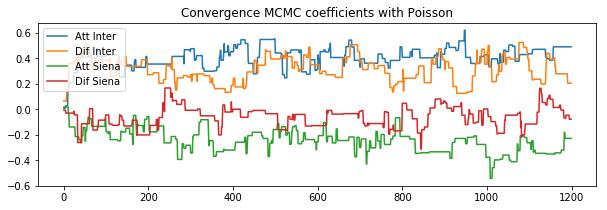

In [19]:
#Plot the evolution of Attacking and difensive Coefficients of Inter and Siena 
def vect(coef):
    
    vect_att_i=[]
    vect_def_i=[]
    vect_att_s=[]
    vect_def_s=[]
    for i in range(it):
        vect1=[]
        vect2=[]
        vect3=[]
        vect4=[]
        col_att = "iter"+str(i)+"att"
        col_def = "iter"+str(i)+"def"
        vect1.append(coef[col_att][8])
        vect2.append(coef[col_def][8])
        vect3.append(coef[col_att][18])
        vect4.append(coef[col_def][18])
        vect_att_i.append(vect1)
        vect_def_i.append(vect2)
        vect_att_s.append(vect3)
        vect_def_s.append(vect4)
    plt.figure(figsize=(10,3))
    plt.plot(vect_att_i, label='Att Inter')
    plt.plot(vect_def_i,label='Dif Inter')
    plt.plot(vect_att_s, label='Att Siena')
    plt.plot(vect_def_s,label='Dif Siena')
    plt.legend(loc='upper left')
    plt.title('Convergence MCMC coefficients with Poisson')
    plt.savefig('MCMC_Poisson.png')
    plt.show()
    return 
vect(Coef_club)


In [15]:
Coef_club

,Att,Dif,Sum_Att,Sum_Dif,New_Att,New_Dif,iter0att,iter0def,iter1att,iter1def,...,iter1195att,iter1195def,iter1196att,iter1196def,iter1197att,iter1197def,iter1198att,iter1198def,iter1199att,iter1199def
Team,,,,,,,,,,,,,,,,,,,,,
Atalanta,0.005565,-0.001015,-0.024221,-0.075977,-0.261640,-0.099074,-0.114359,0.125009,-0.054750,-0.112436,...,0.064466,-0.014826,-0.007651,-0.148584,-0.007651,-0.211022,0.023785,-0.170156,0.015364,-0.087263
Bari,0.014042,-0.017466,-0.046574,0.028818,0.212719,0.149074,0.014042,-0.077815,0.014042,-0.077815,...,-0.002866,0.115418,0.212719,0.115418,0.212719,0.115418,0.212719,0.115418,0.212719,0.149074
Bologna,-0.006743,0.016702,-0.206872,-0.142026,-0.361122,-0.106704,-0.006743,0.016702,-0.006743,0.016702,...,-0.361122,-0.240463,-0.361122,-0.106704,-0.361122,-0.106704,-0.361122,-0.106704,-0.361122,-0.106704
Cagliari,-0.004959,-0.000408,-0.006719,-0.069770,0.046359,-0.064344,-0.004959,-0.000408,-0.004959,-0.000408,...,0.026559,-0.064344,0.026559,-0.064344,0.026559,-0.064344,0.046359,-0.064344,0.046359,-0.064344
Catania,-0.003504,0.001549,-0.192182,-0.017661,-0.284275,0.009759,-0.003504,0.001549,-0.003504,0.001549,...,-0.284275,-0.043326,-0.284275,-0.043326,-0.284275,0.009759,-0.284275,0.009759,-0.284275,0.009759
Chievo,0.007644,0.001237,-0.290591,0.079018,-0.304735,0.177798,0.007644,0.001237,0.007644,0.001237,...,-0.324029,0.177798,-0.304735,0.177798,-0.304735,0.177798,-0.304735,0.177798,-0.304735,0.177798
Fiorentina,-0.000128,0.006342,0.035820,0.153798,0.108441,0.154220,-0.000128,0.006342,-0.179571,0.006342,...,-0.004425,0.154220,-0.004425,0.154220,-0.004425,0.154220,-0.004425,0.154220,-0.004425,0.154220
Genoa,-0.004596,-0.015177,0.040527,-0.067544,0.042053,-0.189004,-0.004596,-0.015177,-0.004596,-0.015177,...,0.042053,-0.068555,0.042053,-0.068555,0.042053,-0.068555,0.042053,-0.189004,0.042053,-0.189004
Inter,0.005893,0.004457,0.406135,0.310904,0.489231,0.204049,0.005893,0.064647,0.005893,0.064647,...,0.489231,0.204049,0.489231,0.204049,0.489231,0.204049,0.489231,0.204049,0.489231,0.204049
